Lecture: AI I - Advanced 

Previous:
[**Chapter 1.1: Multi Layer Perceptron**](../01_basics/02_mlp.ipynb)

---

# Chapter 2.1: Regularization

## The Problem: When Networks Memorize Instead of Learn

You"ve built your network, trained it carefully with gradient descent, and achieved impressively low training loss—but when you test it on new data, performance is disappointing. This is **overfitting**: your model has memorized the training data rather than learning the underlying patterns. It"s like a student who memorizes exam questions word-for-word but can"t apply concepts to new problems.

Overfitting happens because neural networks are incredibly powerful function approximators—given enough parameters, they can fit almost any dataset perfectly, including all the noise and quirks specific to your training data. A network with millions of parameters can easily "remember" thousands of training examples without actually understanding the task.

## The Solution: Regularization Techniques

Regularization refers to a collection of techniques designed to prevent overfitting by constraining or modifying the learning process. The goal isn"t to achieve the lowest possible training loss—it"s to build a model that generalizes well to unseen data. Think of regularization as teaching your network to focus on the signal and ignore the noise.

Regularization techniques work through different mechanisms::
- **Adding constraints** to limit model complexity (weight decay, L1/L2 regularization)
- **Modifying the architecture** to prevent co-adaptation (dropout, batch normalization)
- **Stopping early** before the model has time to memorize (early stopping)

## Recognizing Overfitting

The classic symptom: training loss keeps decreasing while validation loss starts increasing. Your model is getting better at the training set but worse at everything else. Other warning signs include:

- Large gap between train and validation accuracy
- Model performs well on familiar examples but fails on similar but slightly different ones
- Very high model complexity relative to dataset size

In this section, we"ll explore the most effective regularization techniques, understand when and how to apply them, and learn to balance model capacity with generalization. The art of deep learning isn"t just about building powerful models—it"s about building models that work in the real world.

## Early Stopping

In the previous chapter on Multi Layer Perceptrons, you already implemented one important regularization technique: early stopping. By monitoring validation loss and halting training when it stopped improving, you prevented your model from overfitting to the training data. This was your first encounter with regularization in practice. Now we"ll explore additional techniques that give you even more control over your model"s ability to generalize.

## Example: Regularization Techniques for Classification

This example demonstrates both constraint-based (L2 regularization) and architecture-based (Dropout, Batch Normalization) regularization techniques on a simple classification task.

In [1]:
import torch

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader

torch.manual_seed(42)  # set random seed for reproducibility

iris = datasets.load_iris()
x = iris.data  # 4 features: sepal length, sepal width, petal length, petal width
y = iris.target  # 3 classes: setosa, versicolor, virginica

x_scaled = StandardScaler().fit_transform(x)
x_train, x_temp, y_train, y_temp = train_test_split(
    x_scaled, y, test_size=0.4, random_state=42, stratify=y
)
x_val, x_test, y_val, y_test = train_test_split(
    x_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

batch_size = 16
train_loader = DataLoader(TensorDataset(torch.FloatTensor(x_train), torch.LongTensor(y_train)), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(torch.FloatTensor(x_val), torch.LongTensor(y_val)), batch_size=batch_size)
test_loader = DataLoader(TensorDataset(torch.FloatTensor(x_test), torch.LongTensor(y_test)), batch_size=batch_size)

### Baseline Model (No Regularization)

In [2]:
import torch.nn as nn
import torch.nn.functional as F

class BaselineModel(nn.Module):
    """Baseline model WITHOUT regularization - prone to overfitting"""
    def __init__(self, input_dim=4, hidden_dim=64, output_dim=3):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

### L2 Regularization (Weight Decay)

In [3]:
class L2RegularizedModel(nn.Module):
    """Model with L2 regularization (weight decay)
    Constraint-based: Penalizes large weights"""
    def __init__(self, input_dim=4, hidden_dim=64, output_dim=3):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

### Dropout

In [4]:
class DropoutModel(nn.Module):
    """Model with Dropout
    Architecture-based: Randomly deactivates neurons during training"""
    def __init__(self, input_dim=4, hidden_dim=64, output_dim=3, dropout_rate=0.3):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout_rate)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)  # Dropout after first layer
        x = F.relu(self.fc2(x))
        x = self.dropout(x)  # Dropout after second layer
        x = self.fc3(x)
        return x

### Batch Normalization

In [5]:
class BatchNormModel(nn.Module):
    """Model with Batch Normalization
    Architecture-based: Normalizes activations, acts as regularizer"""
    def __init__(self, input_dim=4, hidden_dim=64, output_dim=3):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.fc3(x)
        return x

### Combining Techniques

In [6]:
class CombinedRegularizationModel(nn.Module):
    """Model combining ALL regularization techniques
    - L2 regularization (via optimizer)
    - Dropout
    - Batch Normalization
    """
    def __init__(self, input_dim=4, hidden_dim=64, output_dim=3, dropout_rate=0.3):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.dropout1 = nn.Dropout(dropout_rate)
        
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)
        self.dropout2 = nn.Dropout(dropout_rate)
        
        self.fc3 = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        # Layer 1: Linear → BatchNorm → ReLU → Dropout
        x = self.fc1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout1(x)
        
        # Layer 2: Linear → BatchNorm → ReLU → Dropout
        x = self.fc2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.dropout2(x)
        
        # Output layer
        x = self.fc3(x)
        return x

In [7]:
models = {
    "Baseline (No Regularization)": BaselineModel(),
    "L2 Regularization": L2RegularizedModel(),
    "Dropout": DropoutModel(),
    "Batch Normalization": BatchNormModel(),
    "Combined (L2 + Dropout + BN)": CombinedRegularizationModel()
}

### Training and Evaluation Loop

In [8]:
def train_epoch(model, train_loader, criterion, optimizer):
    """Train for one epoch"""
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0
    
    for batch_X, batch_y in train_loader:
        # Forward pass
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Track metrics
        train_loss += loss.item() * batch_X.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == batch_y).sum().item()
        total += batch_y.size(0)
    
    avg_loss = train_loss / len(train_loader.dataset)
    accuracy = correct / total
    return avg_loss, accuracy


def evaluate(model, data_loader, criterion):
    """Evaluate the model"""
    model.eval()
    eval_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for batch_X, batch_y in data_loader:
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            
            eval_loss += loss.item() * batch_X.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == batch_y).sum().item()
            total += batch_y.size(0)
    
    avg_loss = eval_loss / len(data_loader.dataset)
    accuracy = correct / total
    return avg_loss, accuracy


def train_model(model, train_loader, val_loader, num_epochs=200, lr=0.01, weight_decay=0.0):
    """Complete training loop"""
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    
    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
    for epoch in range(num_epochs):
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer) # Train
        val_loss, val_acc = evaluate(model, val_loader, criterion)  # Validate
        
        # Store history
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)
        
        # Print progress
        if (epoch + 1) % 50 == 0:
            print(f"Epoch {epoch+1:3d}/{num_epochs} | "
                  f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | "
                  f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")
    
    return history

In [9]:
results = {}
for name, model in models.items():
    print(f"\nTraining: {name}")
    print("-" * 70)
    
    history = train_model(
        model, 
        train_loader, 
        val_loader, 
        num_epochs=200,
        lr=0.01,
        weight_decay=0.01 if "L2" in name or "Combined" in name else 0.0
    )
    test_loss, test_acc = evaluate(model, test_loader, nn.CrossEntropyLoss())
    results[name] = {
        "history": history,
        "test_loss": test_loss,
        "test_acc": test_acc
    }


Training: Baseline (No Regularization)
----------------------------------------------------------------------
Epoch  50/200 | Train Loss: 0.0024, Acc: 1.0000 | Val Loss: 0.0901, Acc: 0.9667
Epoch 100/200 | Train Loss: 0.0004, Acc: 1.0000 | Val Loss: 0.1305, Acc: 0.9667
Epoch 150/200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1555, Acc: 0.9667
Epoch 200/200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1687, Acc: 0.9667

Training: L2 Regularization
----------------------------------------------------------------------
Epoch  50/200 | Train Loss: 0.0531, Acc: 0.9889 | Val Loss: 0.0877, Acc: 0.9667
Epoch 100/200 | Train Loss: 0.0580, Acc: 0.9889 | Val Loss: 0.0800, Acc: 0.9667
Epoch 150/200 | Train Loss: 0.0532, Acc: 0.9889 | Val Loss: 0.0866, Acc: 0.9667
Epoch 200/200 | Train Loss: 0.0490, Acc: 0.9889 | Val Loss: 0.0849, Acc: 0.9667

Training: Dropout
----------------------------------------------------------------------
Epoch  50/200 | Train Loss: 0.0692, Acc: 0.9556 | Val Loss:

### Visualize Results

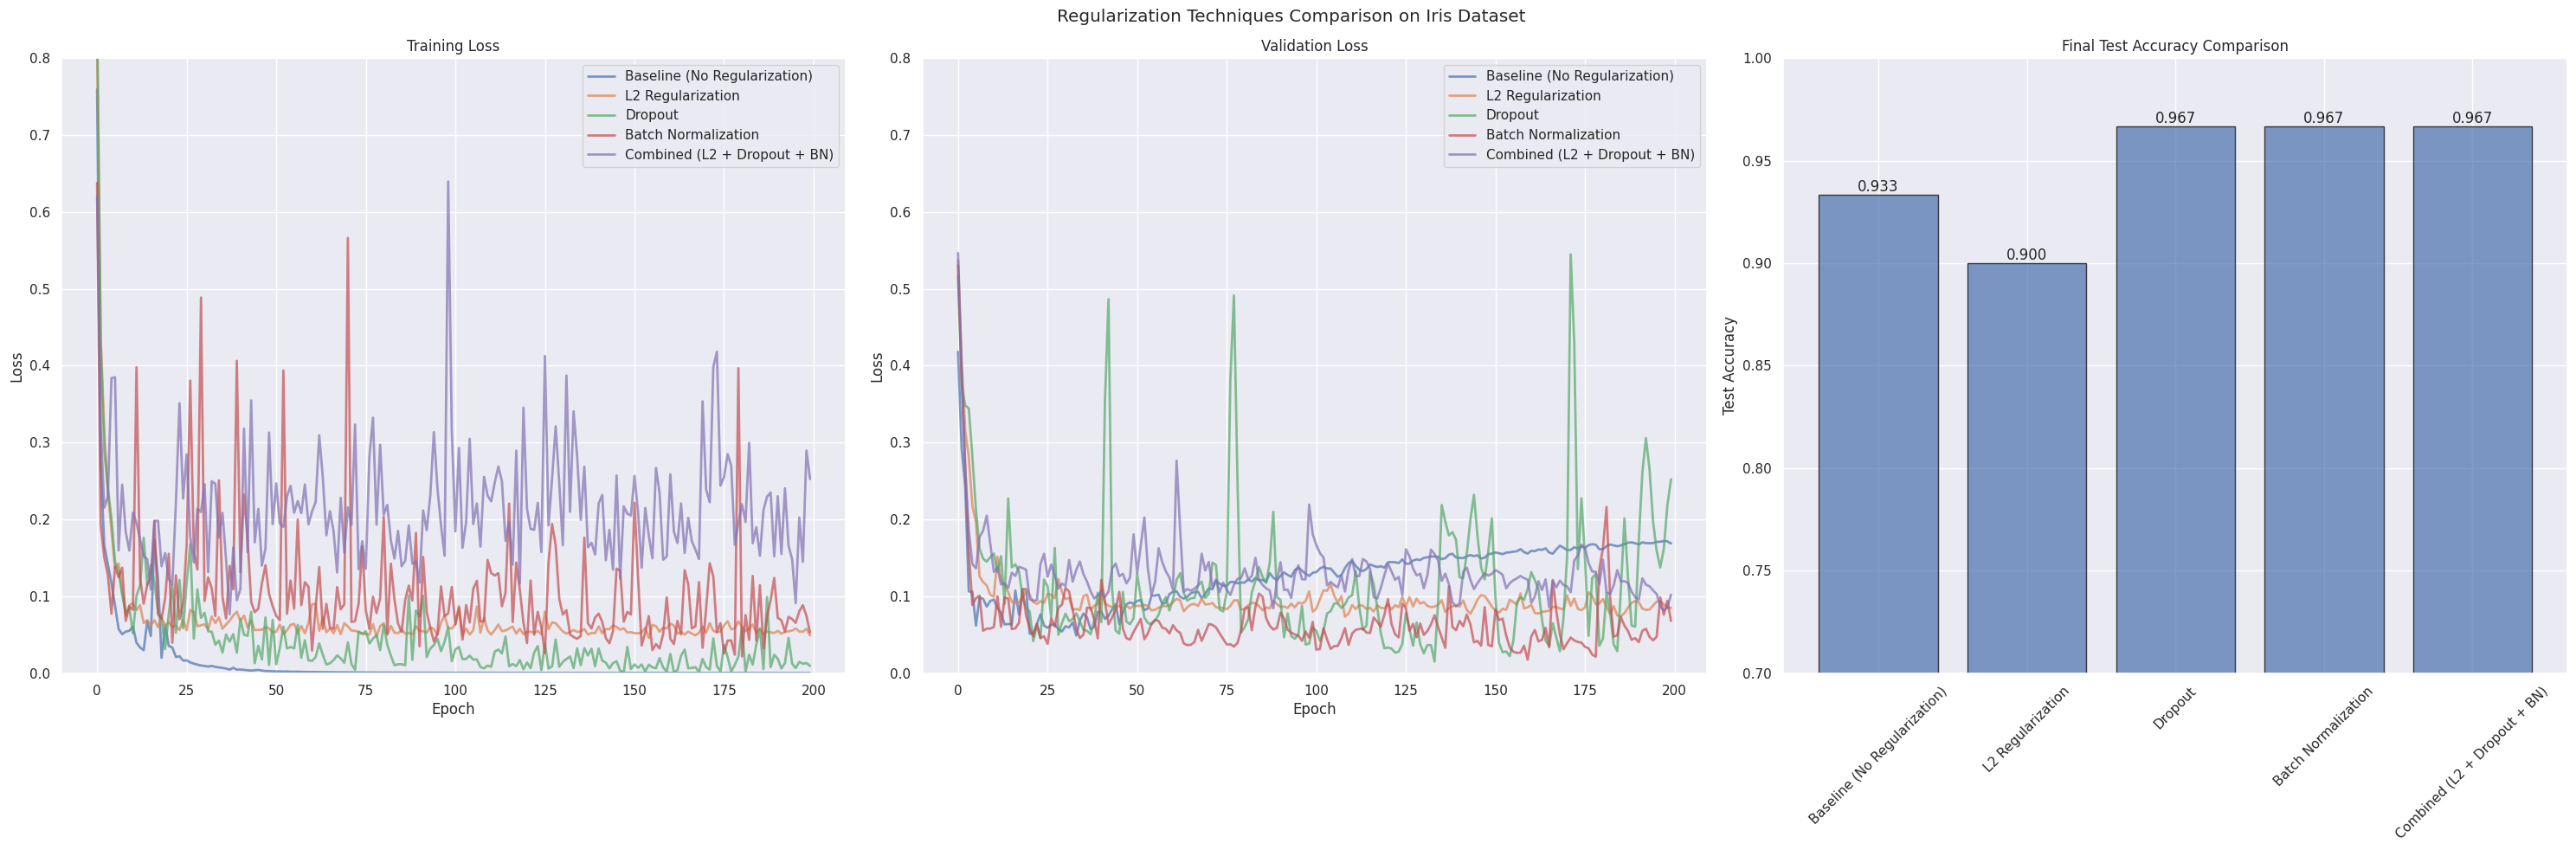

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set_theme(style="darkgrid")
# Create comprehensive comparison visualization
fig, (train_ax, val_ax, test_ax) = plt.subplots(1, 3, figsize=(30, 10))
fig.suptitle("Regularization Techniques Comparison on Iris Dataset")


# 1. Training Loss Comparison
for name, result in results.items():
    train_ax.plot(result["history"]["train_loss"], label=name, alpha=0.7, linewidth=2)
train_ax.set(title="Training Loss", xlabel="Epoch", ylabel="Loss", ylim=(0, .8))
train_ax.legend()

# 2. Validation Loss Comparison
for name, result in results.items():
    val_ax.plot(result["history"]["val_loss"], label=name, alpha=0.7, linewidth=2)
val_ax.set(title="Validation Loss", xlabel="Epoch", ylabel="Loss", ylim=(0, .8))
val_ax.legend()

# 3. Final Test Accuracy Comparison (Bar Chart)
names = list(results.keys())
test_accs = [results[name]["test_acc"] for name in names]
bars = test_ax.bar(range(len(names)), test_accs, alpha=0.7, edgecolor="black")
for bar, acc in zip(bars, test_accs):
    test_ax.text(bar.get_x() + bar.get_width() / 2., bar.get_height(), f"{acc:.3f}", ha="center", va="bottom")

test_ax.set(title="Final Test Accuracy Comparison", ylabel="Test Accuracy", ylim=(0.7, 1.0), xticks=range(len(names)))
test_ax.set_xticklabels(names, rotation=45)

fig.tight_layout()

### Visualize Decision Boundaries 

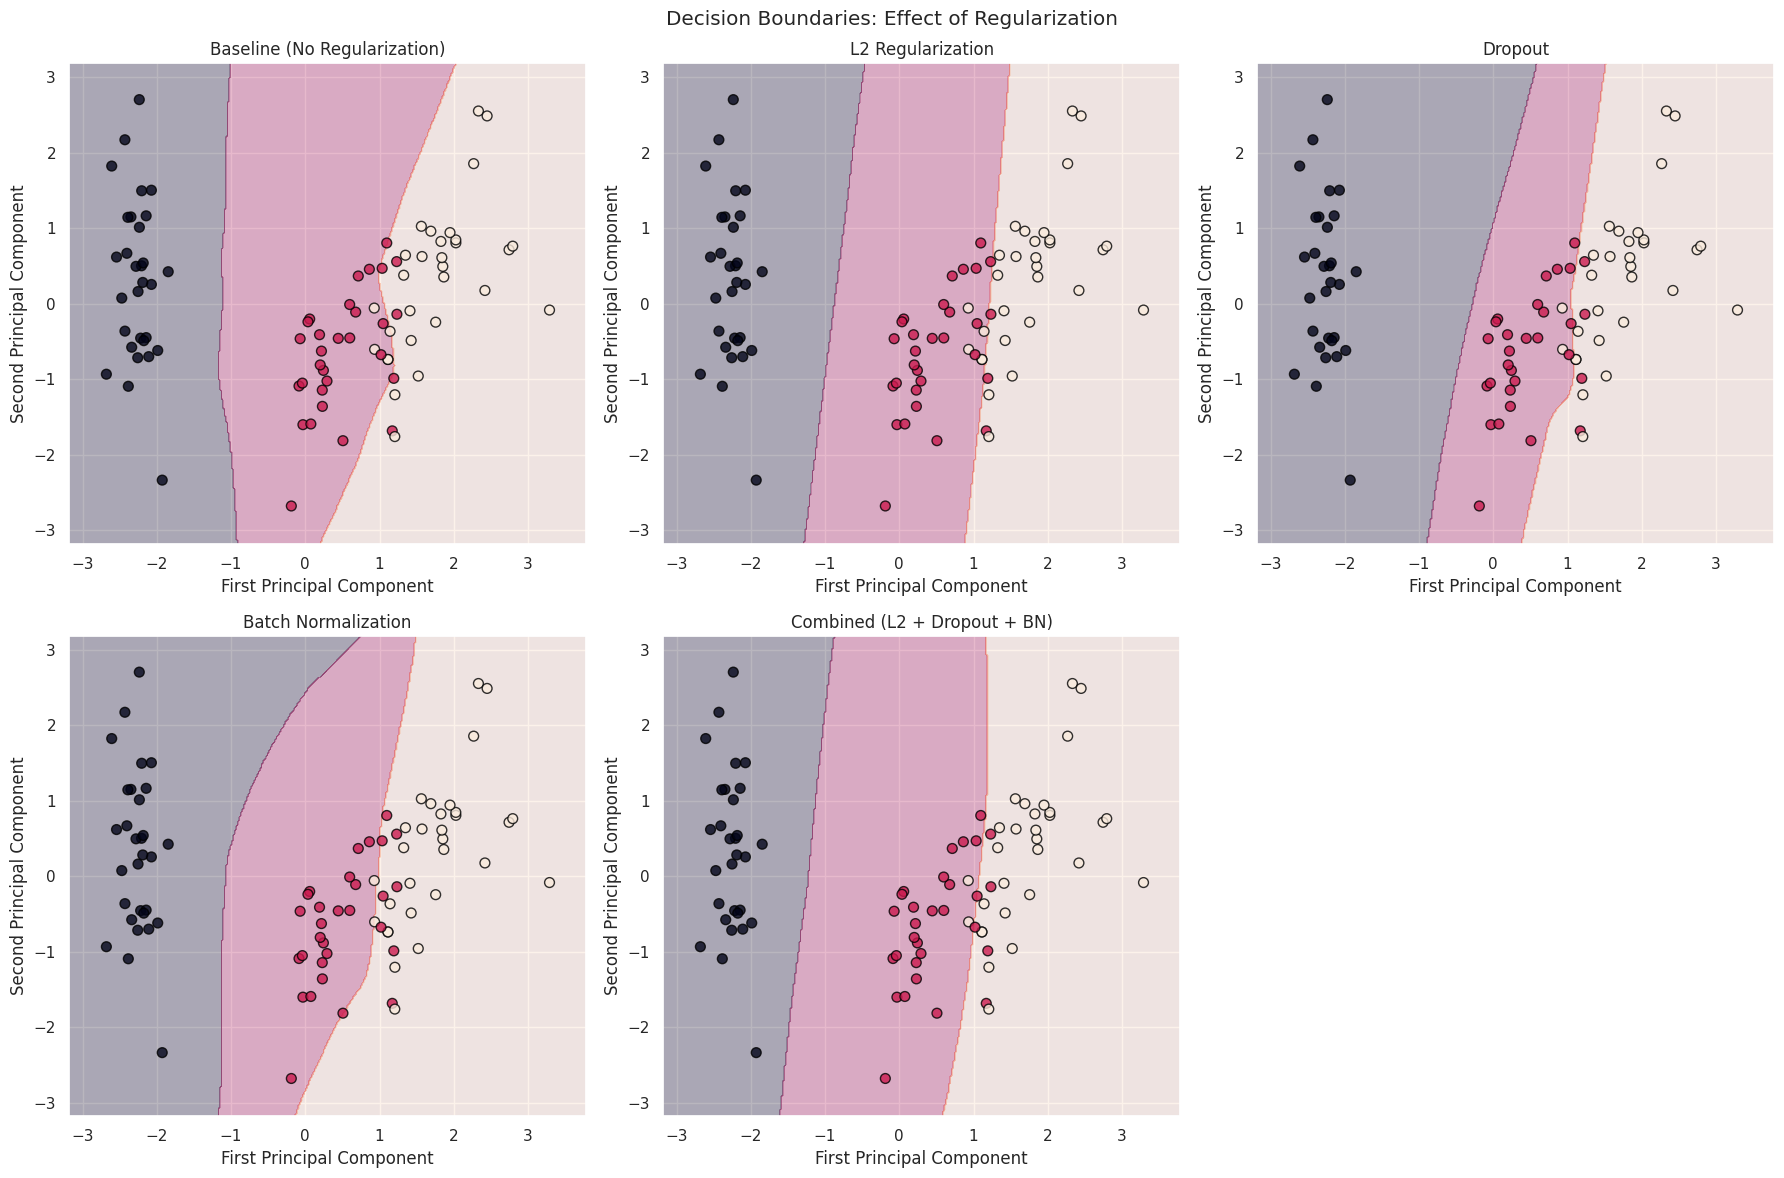

In [11]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2) 
x_train_2d = pca.fit_transform(x_train)  # Project data to 2D for visualization

# Create meshgrid for decision boundary
h = 0.02
x_min, x_max = x_train_2d[:, 0].min() - 0.5, x_train_2d[:, 0].max() + 0.5
y_min, y_max = x_train_2d[:, 1].min() - 0.5, x_train_2d[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle("Decision Boundaries: Effect of Regularization")

for idx, (name, model) in enumerate(models.items()):
    ax = axes[idx // 3, idx % 3]
    
    # Predict on meshgrid
    model.eval()
    with torch.no_grad():
        # Transform meshgrid points back to 4D
        mesh_points = np.c_[xx.ravel(), yy.ravel()]
        mesh_points_4d = pca.inverse_transform(mesh_points)
        mesh_tensor = torch.FloatTensor(mesh_points_4d)
        
        Z = model(mesh_tensor)
        Z = torch.argmax(Z, dim=1).numpy()
        Z = Z.reshape(xx.shape)
    
    # Plot decision boundary
    ax.contourf(xx, yy, Z, alpha=0.3)
    
    # Plot training points
    scatter = ax.scatter(x_train_2d[:, 0], x_train_2d[:, 1], 
                        c=y_train,
                        edgecolors="black", s=50, alpha=0.8)
    
    ax.set(title=name, xlabel="First Principal Component", ylabel="Second Principal Component")

# Remove empty subplot if any
if len(models) < 6:
    fig.delaxes(axes[1, 2])

fig.tight_layout()

---

Lecture: AI I - Basics 

Exercise: [**Exercise 2.1: Regularization**](../02_training/exercises/01_regularization.ipynb)

Next: [**Chapter 2.2: Hyperparameter Tuning**](../02_training/02_optimization.ipynb)